## Figure 4
Results from a parcel simulation with Na = 200 cm-3, ra = 50 nm, Forg = 0.5, and w = 0.5 m/s.
Subplot a) shows the vertical profile of CDNC from cloud base to +200m. Subplot b) shows the droplet size distribution at +200m.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names
from PySDM_examples.Singer_Ward.read_mcmc import get_dict_median_parameters

In [3]:
output = {}

FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume

Ntotal, Ncut = 1000, 500

aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=0.5, N_a=200, r_a=50)
for model in ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl'):
    print(model)
    key = f"{aerosol.__class__.__name__}-{model}"
    settings = Settings(
        dz = 1 * si.m,
        w = 0.5 * si.m / si.s,
        n_sd_per_mode = 100, 
        model = model,
        aerosol = aerosol,
        spectral_sampling = spec_sampling.ConstantMultiplicity,
        stc = get_dict_median_parameters(model, aerosol, Ntotal, Ncut),
    )

    simulation = ParcelSimulation(settings)
    output[key] = simulation.run()
    output[key]['color'] = plot_colors[model]
    output[key]['linestyle'] = plot_lines[model]
    output[key]['Na_tot'] = Sum(
        tuple(settings.aerosol.modes[i]['spectrum']
                for i in range(len(settings.aerosol.modes)))).norm_factor

Constant
CompressedFilmOvadnevaite
SzyszkowskiLangmuir
CompressedFilmRuehl


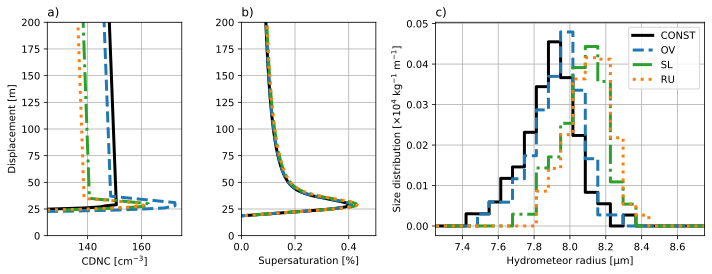

HTML(value="<a href='./fig4.pdf' target='_blank'>./fig4.pdf</a><br>")

In [5]:
fig, axes = pyplot.subplots(1, 3, figsize=(10,4), gridspec_kw={"width_ratios":[1,1,2]})

for i,var in enumerate(("CDNC_cm3", "S_max")):
    ax = axes[i]
    for key, output_k in output.items():
        model = key.split("-")[-1]
        Y = np.asarray(output_k['z'])
        ax.plot(output_k[var], Y, 
                label=plot_names[model], 
                color=output_k['color'],
                linestyle=output_k['linestyle'],
                lw=3,
                )
    ax.set_ylim(0, 200)
    if i == 0:
        ax.set_ylabel('Displacement [m]')
        ax.set_xlim(125,175)
    else:
        ax.sharey(axes[0])
        ax.set_xlim(0)
    ax.grid()
    ax.set_xlabel({0:'CDNC [cm$^{-3}$]', 1:"Supersaturation [%]"}[i])
    ax.set_title({0:"a)", 1:"b)"}[i], loc="left")

#######################

ax = axes[2]
record_number = -1
for key, output_k in output.items():
    model = key.split("-")[-1]
    ax.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        output_k['spectrum'] * si.mg / si.kg * si.um / si.m / 1e4,
        label=plot_names[model],
        color=output_k['color'],
        linestyle=output_k['linestyle'],
        lw=3,
        where='pre'
    )
ax.grid()
ax.legend()
ax.set_xlabel("Hydrometeor radius [μm]")
ax.set_ylabel("Size distribution [$\\times 10^4$ kg$^{-1}$ m$^{-1}$]")
ax.set_xlim(7.25,8.75)
ax.set_title("c)", loc="left")

pyplot.tight_layout()
show_plot("fig4.pdf")